In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import moments
# In demographic_models.py, we've defined a custom model for this problem
import demographic_models

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [2]:
# Load the data
data = moments.Spectrum.from_file('YRI_CEU.fs')
ns = data.sample_sizes

In [3]:
#Define the objective function
def obj_func(parameters_set):
    # We'll work with YRI_CEU custom model
    func = demographic_models.prior_onegrow_mig
    
    lls = []
    for parameters in parameters_set:
        # Calculate the model AFS.
#         print parameters
        model = func(parameters, ns)
        # Likelihood of the data given the model AFS.
        ll_model = moments.Inference.ll_multinom(model, data)
        
        lls.append([-ll_model])  # minus for maximization
    return np.array(lls)

In [4]:
# The upper_bound and lower_bound lists are for use in optimization.
# Occasionally the optimizer will try wacky parameter values. We in particular
# want to exclude values with very long times, very small population sizes, or
# very high migration rates, as they will take a long time to evaluate.
# Parameters are: (nu1F, nu2B, nu2F, m, Tp, T)
upper_bound = np.array([100, 100, 100, 10, 3, 3])
lower_bound = np.array([1e-2, 1e-2, 1e-2, 0, 0, 0])

In [5]:
domain = np.array([{'name': 'X' + str(bd), 'type': 'continuous', 'domain': bd} 
                   for bd in zip(lower_bound, upper_bound)])

In [6]:
# This is our initial guess for the parameters, which is somewhat arbitrary.
p0 = np.array([[2, 0.1, 2, 1, 0.2, 0.2]])

In [7]:
# Perturb our parameters before optimization. This does so by taking each
# parameter a up to a factor of two up or down.
p0 = moments.Misc.perturb_params(p0, fold=1, upper_bound=upper_bound,
                                 lower_bound=lower_bound)
p0

array([[1.28711612, 0.06435581, 1.28711612, 0.64355806, 0.12871161,
        0.12871161]])

In [9]:
# Now create BO object
bo = BayesianOptimization(f=obj_func, 
                          domain=domain,
                          model_type='GP',
                          kernel=GPy.kern.Matern52(input_dim=p0.shape[0]),
                          acquisition_type ='EI',
                          acquisition_jitter = 0.01,
                          X=p0)

In [16]:
# --- Stop conditions
max_iter  = 20
tolerance = 1e-8 # distance between two consecutive observations 
                 # if we're sampling a region in such fine detail 
                 # then it is likely that we've found the true min.

bo.run_optimization(max_iter=max_iter, eps = tolerance, verbosity=True)

num acquisition: 1, time elapsed: 2.19s
num acquisition: 2, time elapsed: 5.00s
num acquisition: 3, time elapsed: 7.37s
num acquisition: 4, time elapsed: 9.92s
num acquisition: 5, time elapsed: 12.79s
num acquisition: 6, time elapsed: 14.94s
num acquisition: 7, time elapsed: 17.47s
num acquisition: 8, time elapsed: 24.65s
num acquisition: 9, time elapsed: 26.96s
num acquisition: 10, time elapsed: 29.26s
num acquisition: 11, time elapsed: 32.11s
num acquisition: 12, time elapsed: 34.83s
num acquisition: 13, time elapsed: 37.33s
num acquisition: 14, time elapsed: 40.33s
num acquisition: 15, time elapsed: 42.93s
num acquisition: 16, time elapsed: 45.60s
num acquisition: 17, time elapsed: 48.90s
num acquisition: 18, time elapsed: 51.86s
num acquisition: 19, time elapsed: 54.33s
num acquisition: 20, time elapsed: 56.76s


<IPython.core.display.Javascript object>


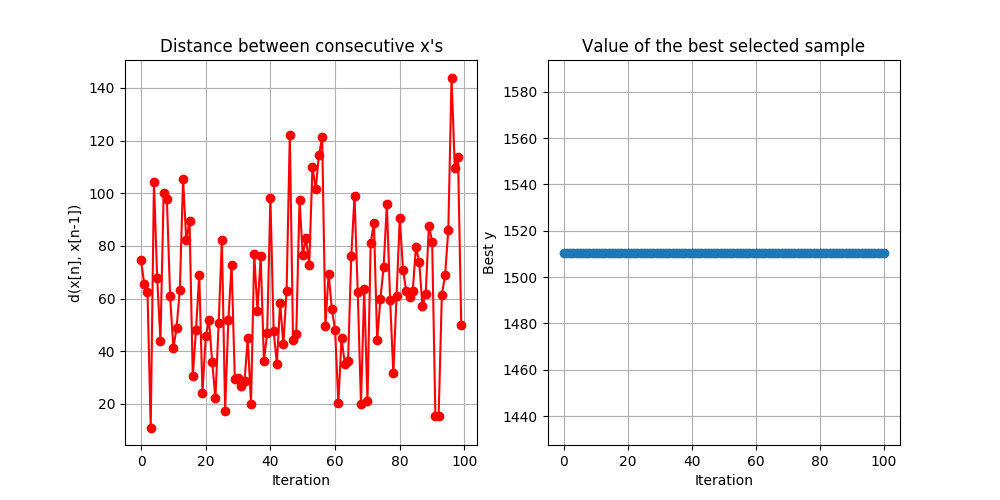

In [11]:
%matplotlib notebook
bo.plot_convergence()

In [15]:
print 'The minumum value obtained by the function was %.4f (x = %s)' % (bo.fx_opt, np.array2string(bo.x_opt))

The minumum value obtained by the function was 1510.6376 (x = [1.28711612 0.06435581 1.28711612 0.64355806 0.12871161 0.12871161])
